Dataset loaded — 1715 samples, 201 features.


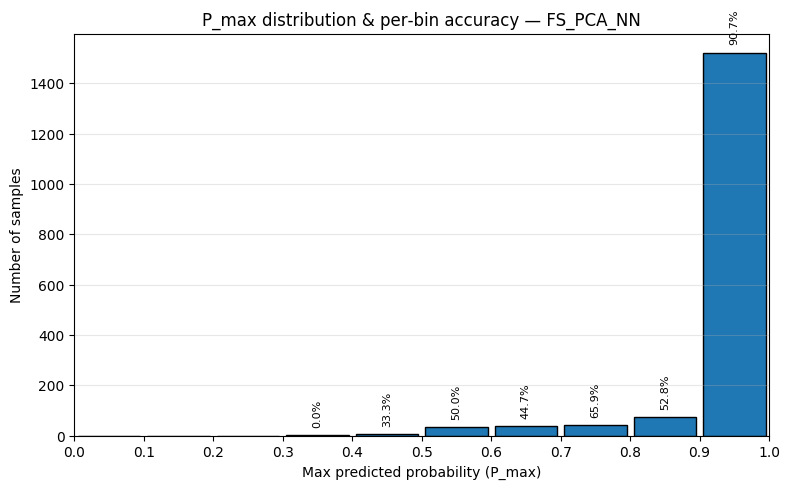

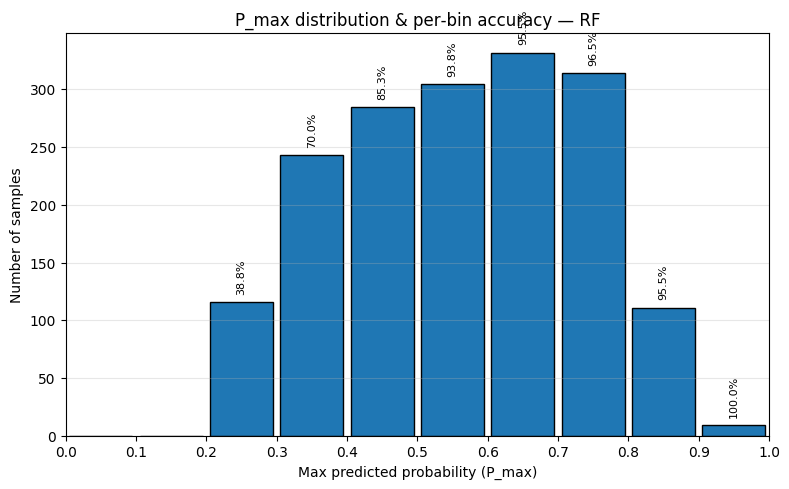

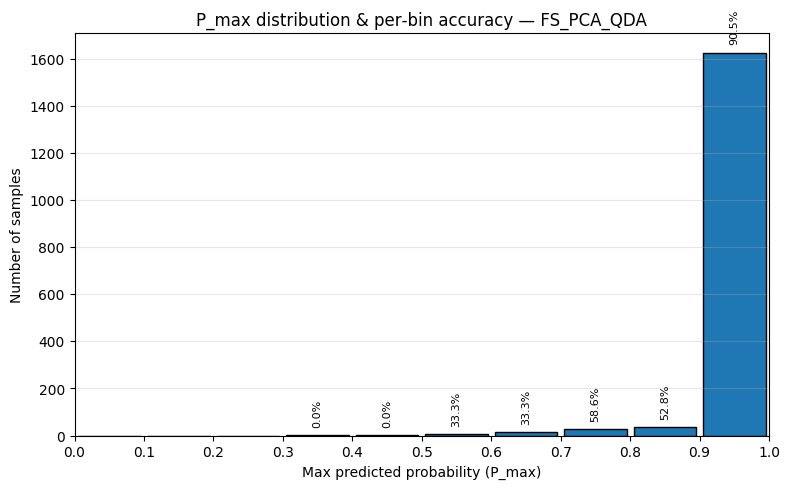

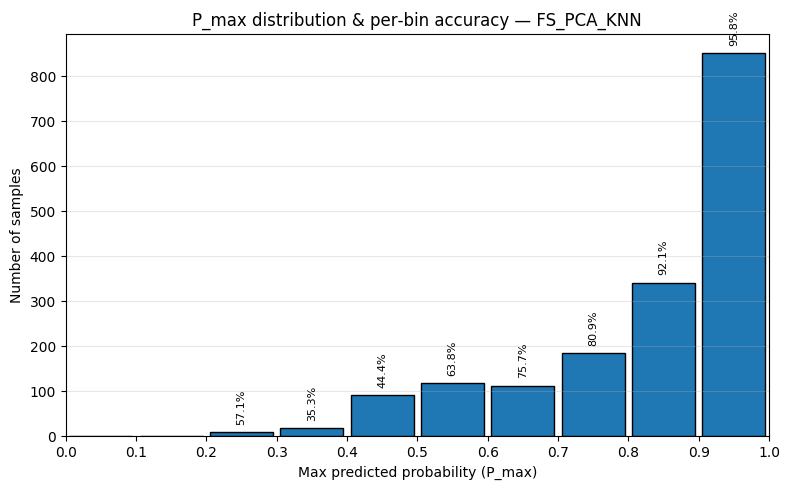

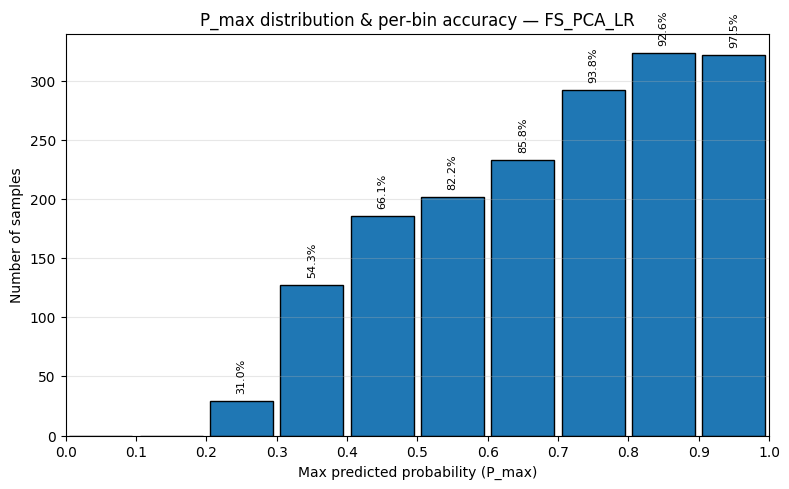

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Paths & constants =====================================================
DATA_ROOT = os.getenv('DATA_ROOT', '.')
DATA_PATH = os.path.join(DATA_ROOT, 'Cancer2025exam.csv')

OUTPUT_ROOT = os.path.join(DATA_ROOT, 'output')
INDICES_DIR = os.path.join(OUTPUT_ROOT, 'indices')
PROBABILITIES_DIR = os.path.join(OUTPUT_ROOT, 'probabilities')

N_FOLDS = 10
MODEL_SET = ['FS_PCA_NN', 'RF', 'FS_PCA_QDA', 'FS_PCA_KNN', 'FS_PCA_LR']  # exclude SVM

# === 2. Load ground‑truth labels ==============================================
df = pd.read_csv(DATA_PATH)
y_true_all = df.iloc[:, 0].values      # first column is label
print(f"Dataset loaded — {len(y_true_all)} samples, {df.shape[1] - 1} features.")

# === 3. Helper: aggregate p_max & correctness per model =======================
bin_edges = np.linspace(0, 1, 11)          # 10 bins: [0,0.1),[0.1,0.2),..., [0.9,1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_data = {}          # model -> (counts_total, counts_correct)

for model in MODEL_SET:
    counts_total = np.zeros(10, dtype=int)
    counts_correct = np.zeros(10, dtype=int)
    
    for fold in range(1, N_FOLDS + 1):
        prob_file = os.path.join(PROBABILITIES_DIR, f"pred_dist_{model}_{fold}.npy")
        if not os.path.exists(prob_file):
            continue
        
        # columns = [sample_id, p_class0, p_class1, ...]
        arr = np.load(prob_file)
        sample_ids = arr[:, 0].astype(int)
        probs = arr[:, 1:]
        
        p_max = probs.max(axis=1)
        y_pred = probs.argmax(axis=1) + 1         # predicted class (by max‑prob)
        y_true = y_true_all[sample_ids]        # ground‑truth labels for those ids
        correct_flags = (y_pred == y_true)
        
        # accumulate per bin
        for p, correct in zip(p_max, correct_flags):
            # ensure p=1.0 ends up in last bin
            bin_idx = min(int(p * 10), 9)
            counts_total[bin_idx] += 1
            if correct:
                counts_correct[bin_idx] += 1

    
    hist_data[model] = (counts_total, counts_correct)

# === 4. Plot per‑model histograms =============================================
save_dir = os.path.join(OUTPUT_ROOT, 'pmax_histograms')
os.makedirs(save_dir, exist_ok=True)

for model, (total, corr) in hist_data.items():
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.bar(bin_centers, total, width=0.09, align='center', edgecolor='black')
    ax.set_xlabel('Max predicted probability (P_max)')
    ax.set_ylabel('Number of samples')
    ax.set_title(f'P_max distribution & per‑bin accuracy — {model}')
    ax.set_xticks(bin_edges)
    ax.set_xlim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # annotate accuracy on bars
    for i, (cnt, cor) in enumerate(zip(total, corr)):
        if cnt > 0:
            acc_pct = cor / cnt * 100
            ax.text(bin_centers[i], cnt + max(total)*0.02, f'{acc_pct:.1f}%', 
                    ha='center', va='bottom', fontsize=8, rotation=90)
    
    fig.tight_layout()
    fname = os.path.join(save_dir, f'pmax_hist_{model}.png')
    plt.savefig(fname, dpi=300)
    plt.show()




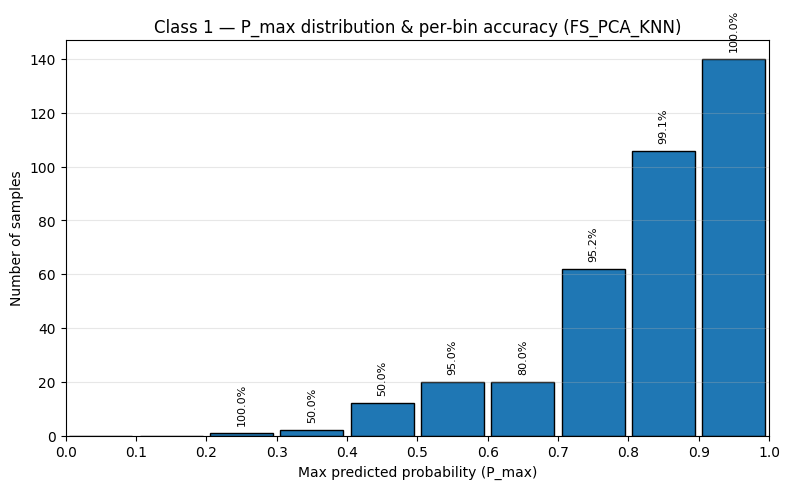

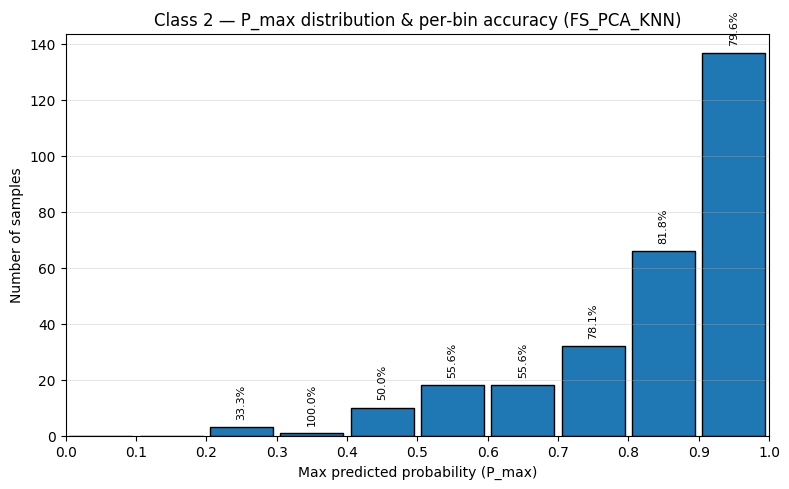

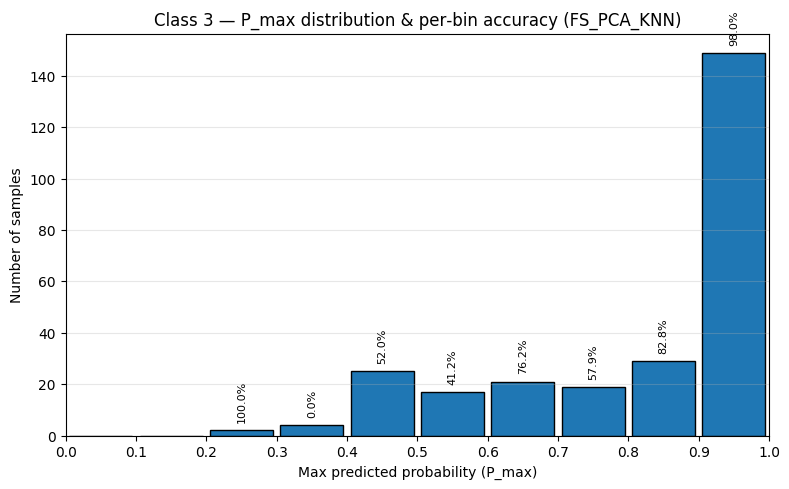

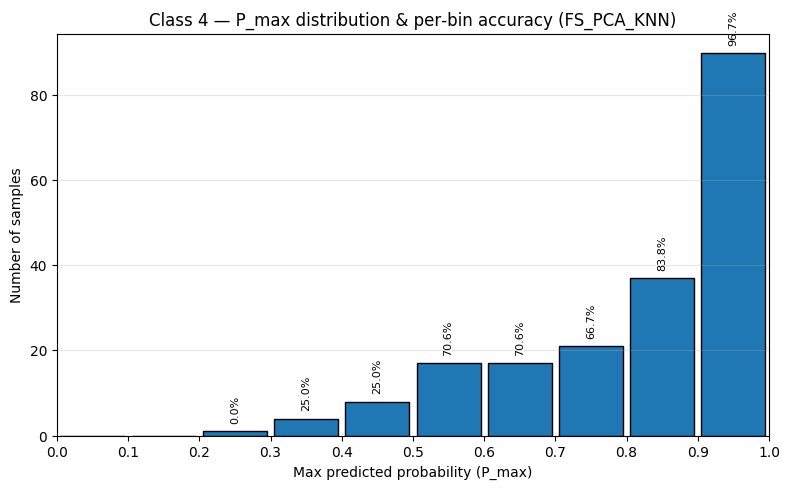

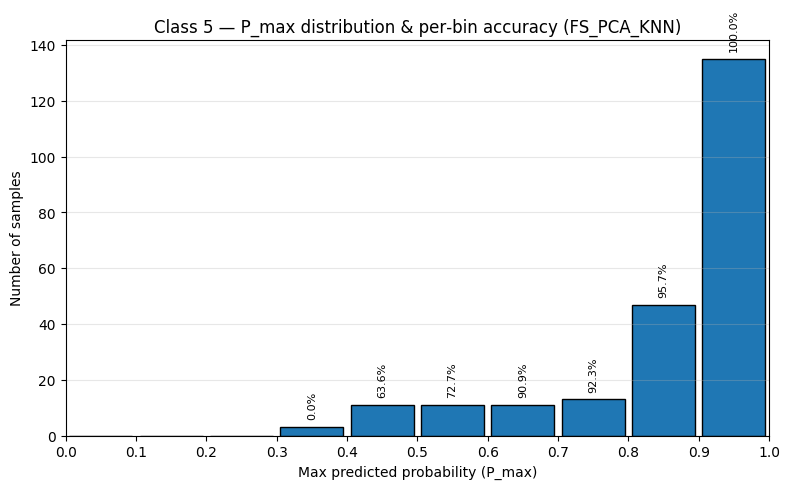

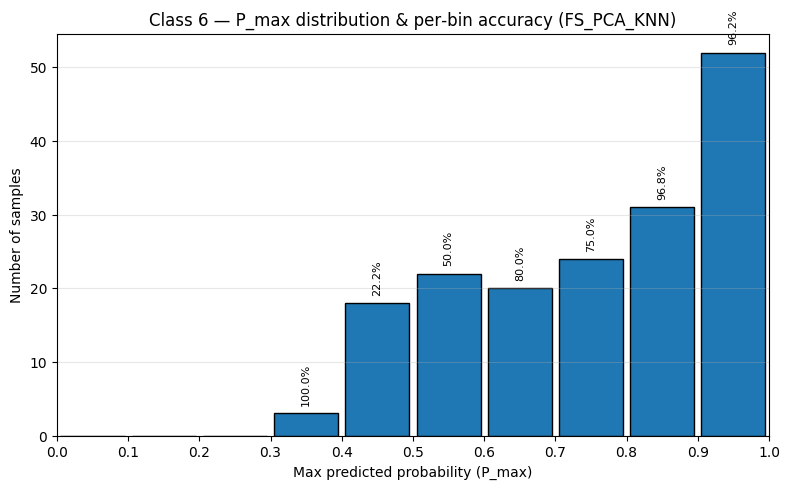

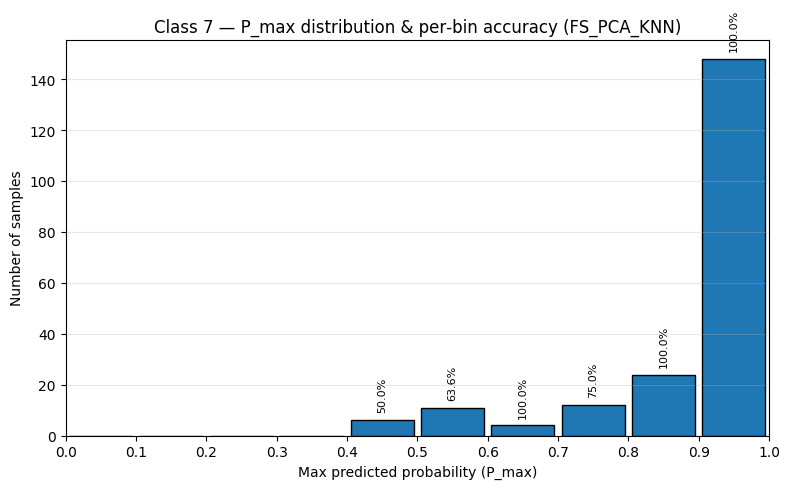

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Paths & constants =====================================================
DATA_ROOT = os.getenv('DATA_ROOT', '.')
DATA_PATH = os.path.join(DATA_ROOT, 'Cancer2025exam.csv')

OUTPUT_ROOT = os.path.join(DATA_ROOT, 'output')
INDICES_DIR = os.path.join(OUTPUT_ROOT, 'indices')
PROBABILITIES_DIR = os.path.join(OUTPUT_ROOT, 'probabilities')

MODEL_NAME = 'FS_PCA_KNN'
N_FOLDS = 10
BIN_EDGES = np.linspace(0, 1, 11)  # 10 bins
BIN_CENTERS = (BIN_EDGES[:-1] + BIN_EDGES[1:]) / 2

# === 2. Load ground‑truth labels ==============================================
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Cannot find dataset at {DATA_PATH}. Adjust DATA_PATH if necessary.")

df = pd.read_csv(DATA_PATH)
y_true_all = df.iloc[:, 0].values
unique_labels = np.unique(y_true_all)

# === 3. Accumulate p_max & correctness per class ==============================
# For each class -> (total_counts, correct_counts)
class_hist_data = {cl: (np.zeros(10, dtype=int), np.zeros(10, dtype=int)) for cl in unique_labels}

for fold in range(1, N_FOLDS + 1):
    prob_file = os.path.join(PROBABILITIES_DIR, f"pred_dist_{MODEL_NAME}_{fold}.npy")
    if not os.path.exists(prob_file):
        continue
    
    arr = np.load(prob_file)
    sample_ids = arr[:, 0].astype(int)
    probs = arr[:, 1:]
    
    p_max = probs.max(axis=1)
    y_pred = probs.argmax(axis=1) + 1
    y_true = y_true_all[sample_ids]
    
    for p, t, pred in zip(p_max, y_true, y_pred):
        bin_idx = min(int(p * 10), 9)
        total, correct = class_hist_data[t]
        total[bin_idx] += 1
        if pred == t:
            correct[bin_idx] += 1

# === 4. Plot per‑class histograms =============================================
save_dir = os.path.join(OUTPUT_ROOT, 'pmax_histograms_classwise')
os.makedirs(save_dir, exist_ok=True)

for cl in unique_labels:
    total, correct = class_hist_data[cl]
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(BIN_CENTERS, total, width=0.09, align='center', edgecolor='black')
    
    ax.set_xlabel('Max predicted probability (P_max)')
    ax.set_ylabel('Number of samples')
    ax.set_title(f'Class {cl} — P_max distribution & per‑bin accuracy ({MODEL_NAME})')
    ax.set_xticks(BIN_EDGES)
    ax.set_xlim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    for i, (cnt, cor) in enumerate(zip(total, correct)):
        if cnt > 0:
            acc_pct = cor / cnt * 100
            ax.text(BIN_CENTERS[i], cnt + max(total)*0.02, f'{acc_pct:.1f}%', 
                    ha='center', va='bottom', fontsize=8, rotation=90)
    
    fig.tight_layout()
    fname = os.path.join(save_dir, f'class_{cl}_pmax_hist_{MODEL_NAME}.png')
    plt.savefig(fname, dpi=300)
    plt.show()


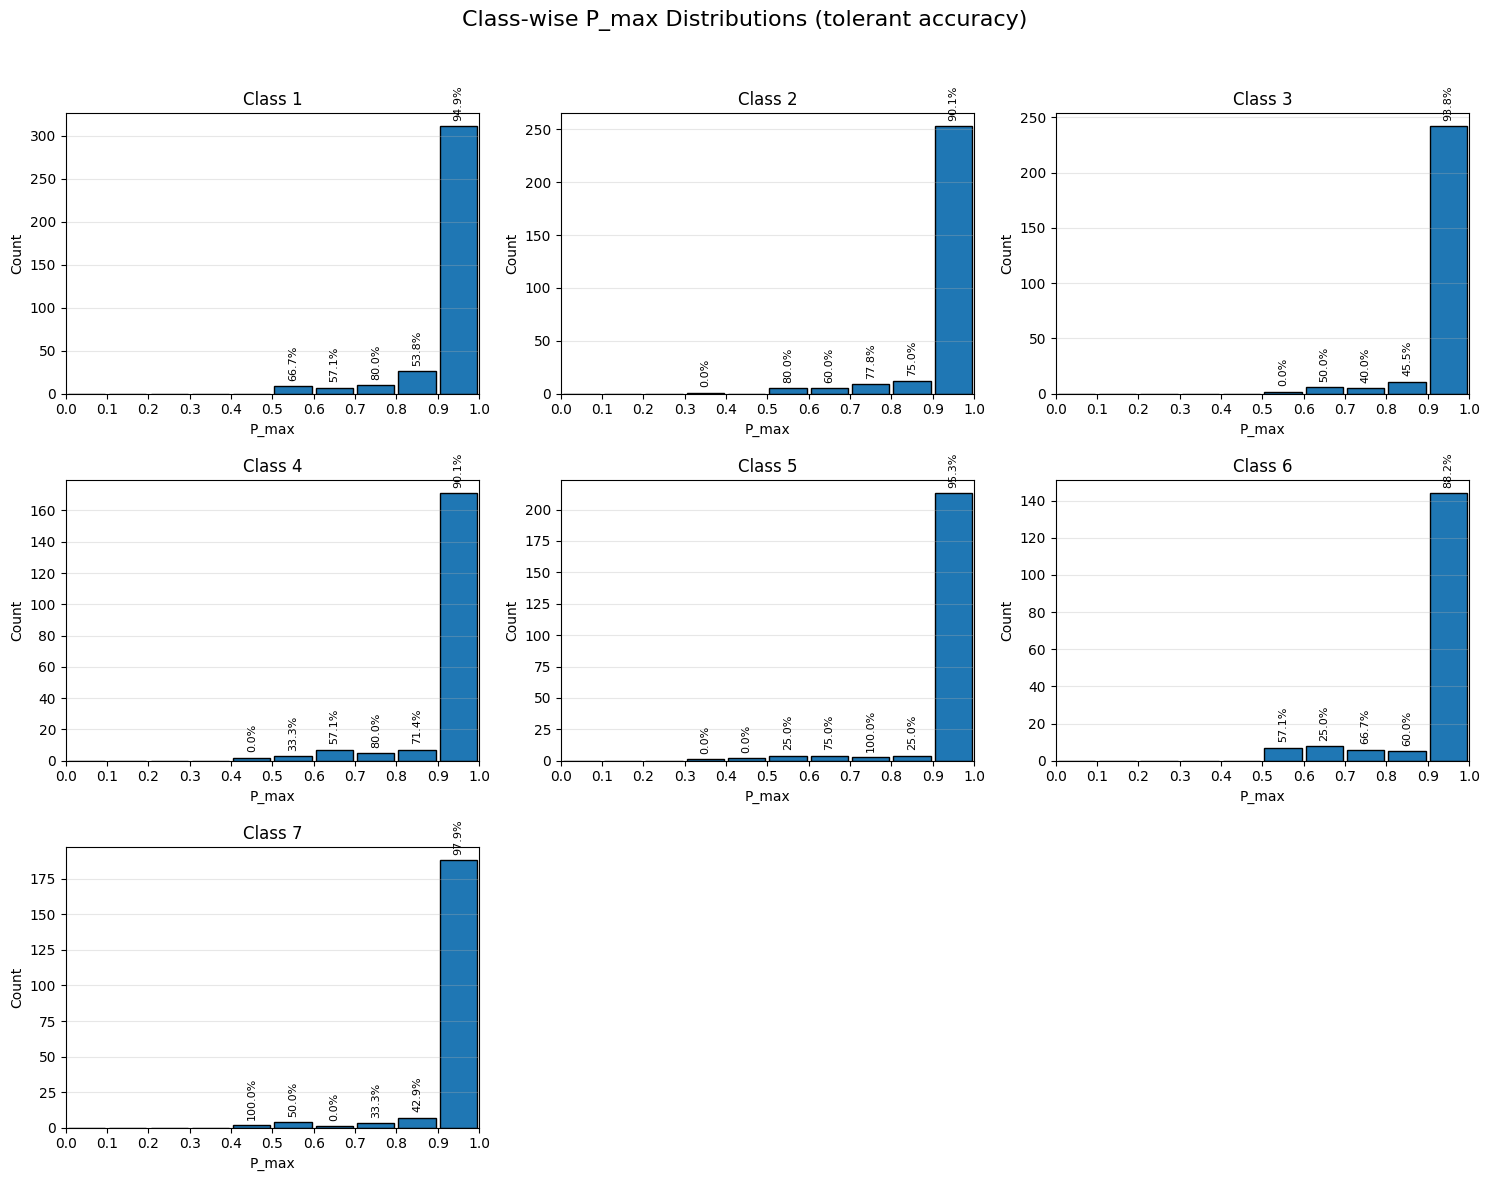

In [11]:
#!/usr/bin/env python3
# ============================================================
#  Class-wise P_max histograms with tolerant accuracy rule
# ============================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1. 目录与常量 ----------
DATA_ROOT   = '.'                     # 根目录自行调整
DATA_PATH   = os.path.join(DATA_ROOT, 'Cancer2025exam.csv')
OUTPUT_ROOT = os.path.join(DATA_ROOT, 'output')
PROBA_DIR   = os.path.join(OUTPUT_ROOT, 'probabilities')
MODEL_NAME  = 'FS_PCA_NN'
N_FOLDS     = 10

BIN_EDGES   = np.linspace(0, 1, 11)           # 10 个宽度 =0.1 的 bin
BIN_CENTERS = (BIN_EDGES[:-1] + BIN_EDGES[1:]) / 2

# ---------- 2. 读入真实标签 ----------
df          = pd.read_csv(DATA_PATH)
y_true_all  = df.iloc[:, 0].values            # 第一列是真实标签
unique_lbls = np.unique(y_true_all)           # 这里应为 [1,2,3,4,5,6,7]

# ---------- 3. 为每个真实类别累积 (total, correct) ----------
hist_dict = {cl: (np.zeros(10, int), np.zeros(10, int)) for cl in unique_lbls}

for fold in range(1, N_FOLDS + 1):
    fpath = os.path.join(PROBA_DIR,
                         f'pred_dist_{MODEL_NAME}_{fold}.npy')
    if not os.path.exists(fpath):
        print(f'*** 跳过：{fpath} 不存在')
        continue

    arr        = np.load(fpath)               # col0 = sample_id
    sample_ids = arr[:, 0].astype(int)
    probs      = arr[:, 1:]
    p_max      = probs.max(axis=1)
    top1       = probs.argmax(axis=1)
    # 取第二高概率对应的类别索引
    top2       = np.argsort(-probs, axis=1)[:, 1]

    y_true = y_true_all[sample_ids]

    for p, y, t1, t2 in zip(p_max, y_true, top1, top2):
        bin_id = min(int(p * 10), 9)          # p=1 包进最后一个 bin
        tot, cor = hist_dict[y]
        tot[bin_id] += 1

        # ---------- 容错判定 ----------
        if t1 == 0:                           # 🌟 注意：若类别从 1 开始，
            pred_top_lbl = t1 + 1             #   需 +1 对齐真实标签
            pred_second  = t2 + 1
        else:
            pred_top_lbl = t1 + 1
            pred_second  = t2 + 1

        if pred_top_lbl == 1:
            # top-1 为 1，则 {top1, top2} 有一个匹配就算对
            if y in (pred_top_lbl, pred_second):
                cor[bin_id] += 1
        else:
            # 普通情况：top-1 必须匹配
            if y == pred_top_lbl:
                cor[bin_id] += 1

# ---------- 4. 出图 ----------
SAVE_DIR = os.path.join(OUTPUT_ROOT,
                        'pmax_histograms_classwise_tolerant')
os.makedirs(SAVE_DIR, exist_ok=True)
import math
import matplotlib.pyplot as plt

n_classes   = len(unique_lbls)               # 这里是 7
n_cols      = 3                              # 想排几列都行
n_rows      = math.ceil(n_classes / n_cols)

fig, axes   = plt.subplots(n_rows, n_cols,
                           figsize=(n_cols * 5, n_rows * 4),
                           squeeze=False)    # axes 是二维数组

for idx, cl in enumerate(sorted(unique_lbls)):
    row, col = divmod(idx, n_cols)
    ax       = axes[row][col]

    total, correct = hist_dict[cl]
    ax.bar(BIN_CENTERS, total,
           width=0.09, align='center',
           edgecolor='black')
    ax.set_title(f'Class {cl}')
    ax.set_xlabel('P_max')
    ax.set_ylabel('Count')
    ax.set_xticks(BIN_EDGES)
    ax.set_xlim(0, 1)
    ax.grid(axis='y', alpha=0.3)

    ymax = total.max() if total.max() > 0 else 1
    for i, (cnt, cor) in enumerate(zip(total, correct)):
        if cnt > 0:
            pct = cor / cnt * 100
            ax.text(BIN_CENTERS[i], cnt + ymax * 0.02,
                    f'{pct:.1f}%', ha='center',
                    va='bottom', fontsize=8, rotation=90)

# 如果子图格子比类别多，把多余的轴关掉
for j in range(idx + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    axes[row][col].axis('off')

fig.suptitle('Class-wise P_max Distributions (tolerant accuracy)',
             fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])      # 给总标题留空间
plt.show()                                   # 只显示，不保存 
